## Decision tree learning pros and cons
### Advantages:

Easy to understand and interpret, perfect for visual representation. This is an example of a white box model, which closely mimics the human decision-making process.\

Can work with numerical and categorical features.\

Requires little data preprocessing: no need for one-hot encoding, dummy variables, and so on.

Non-parametric model: no assumptions about the shape of data.
Fast for inference.

Feature selection happens automatically: unimportant features will not influence the result. The presence of features that depend on each other (multicollinearity) also doesn't affect the quality.


### Disadvantages:

It tends to overfit. This usually can be mitigated in one of three ways:
Limiting tree depth ...

优点

决策树易于理解和解释，可以可视化分析，容易提取出规则；
可以同时处理标称型和数值型数据；
比较适合处理有缺失属性的样本；
能够处理不相关的特征；
测试数据集时，运行速度比较快；
在相对短的时间内能够对大型数据源做出可行且效果良好的结果。
缺点

容易发生过拟合（随机森林可以很大程度上减少过拟合）；
容易忽略数据集中属性的相互关联；

C:\Users\carso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Entropy: -plog(p)')

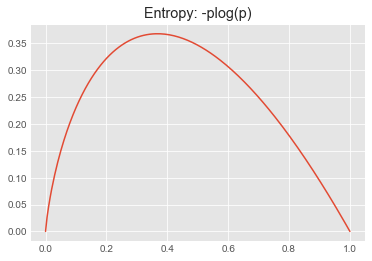

In [14]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = np.linspace(0.0000001, 1.0, num = 200)
y = [-x_i*math.log(x_i) for x_i in x]
sns.lineplot(x,y).set_title('Entropy: -plog(p)')


In [74]:
from collections import defaultdict
from collections import Counter
import math
from functools import partial

# 输入每一种标签class的概率
def entropy(class_probs):
    return sum(-p * math.log(p,2)
              for p in class_probs if p>0)  #0概率跳过

# 根据原始数据计算每一类的概率probs
def class_probs(labels):
    total_counts = len(labels)
    return [count / total_counts
           for count in Counter(labels).values()]

# labeled_data: pari (input, label)
def data_entropy(labeled_data):
    labels = [label for _, label in labeled_data]
    probs = class_probs(labels)
    
    return entropy(probs)


# 计算 S 分为 S1 S2 ... Sp 子集后的信息熵
# 输入为 类别标签数据 [1,1,1, 0,0]
def partition_entropy(subsets):
    total_count = sum(len(subset) for subset in subsets)
    

    return sum( data_entropy(subset) * len(subset) / total_count
                for subset in subsets )

# 输入例子
# 9 1s and 5 0s
# a = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# entropy(class_probs(a))
# =0.940285
   
# ID3 算法
# 采用贪心算法，只考虑当前最优点
# input:(attritube_dict, label)
# return: {attribute_value -> inputs}
def partition_by(inputs, attribute):
    groups = defaultdict(list)
    
    for _input in inputs:
        key = _input[0][attribute] # get the value of the specified attribute
        groups[key].append(_input) # then add this input to the correct list
        
    return groups


# 计算当前partition方式的entropy
def partition_entropy_by(inputs, attribute):
    partitions = partition_by(inputs, attribute)
    
    return partition_entropy(partitions.values())


# test above
# for key in ['Weather','Temp','Humd','Windy']:
#     print(key, partition_entropy_by(inputs2, key))

########################
# build tree
# predict 结果，根据现有的树
def predict(tree, _input):
    #if leaf node return its value
    if tree in [True, False]:
        return tree
    
    # 要根据attribute 继续分
    # dict 的key是attritube的值， 比如 {'weather':'rain', ...}, key是下雨
    attritube, subtree_dict = tree
    subtree_key = _input.get(attritube)
    
    if subtree_key not in subtree_dict:
        subtree_key = None
    
    # 选对应的子树
    subtree = subtree_dict[subtree_key]
    return predict(subtree, _input)

# 最后一步
# 构建树, 第一步所有节点都为候选
def build_tree_id3(inputs, split_candidates=None):
    if split_candidates == None:
        split_candidates = inputs[0][0].keys()
    
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues
    
    # 计算输入数据的 T 和 F
    # 没有 T， 该subset很纯，直接返回 F
    if num_trues == 0: return False 
    if num_falses == 0: return True
    
    # 分割用完所有属性了, 返回当前最多的标签类别
    if not split_candidates:
        if num_trues >= num_false:
            return False 
        else:
            return True
        
    
    # 返回 熵 最大的节点
    best_attribute = min(split_candidates,
                         key=partial(partition_entropy_by, inputs))
    
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates if a != best_attribute]
    
    #递归建立子树
    subtrees = { attribute_value : build_tree_id3(subset, new_candidates)
                for attribute_value, subset in partitions.items() }
    
    #默认情况
    subtrees[None] = num_trues > num_falses
    
    
    return (best_attribute, subtrees)
    
    

In [82]:
if __name__ == "__main__":
    
    inputs2 = [
        ({'Weather':'rain','Temp':'hot','Humd':'high','Windy':'no'},   False),
        ({'Weather':'rain','Temp':'hot','Humd':'high','Windy':'yes'},  False),
        ({'Weather':'cloudy','Temp':'hot','Humd':'high','Windy':'no'},  True),
        ({'Weather':'sunny','Temp':'warm','Humd':'high','Windy':'no'},  True),
        ({'Weather':'sunny','Temp':'cool','Humd':'mid','Windy':'no'},      True),
        ({'Weather':'sunny','Temp':'cool','Humd':'mid','Windy':'yes'},    False),
        ({'Weather':'cloudy','Temp':'cool','Humd':'mid','Windy':'yes'},        True),
        ({'Weather':'rain','Temp':'warm','Humd':'high','Windy':'no'}, False),
        ({'Weather':'rain','Temp':'cool','Humd':'mid','Windy':'no'},      True),
        ({'Weather':'sunny','Temp':'warm','Humd':'mid','Windy':'no'}, True),
        ({'Weather':'rain','Temp':'warm','Humd':'mid','Windy':'yes'},True),
        ({'Weather':'cloudy','Temp':'warm','Humd':'high','Windy':'yes'},    True),
        ({'Weather':'cloudy','Temp':'hot','Humd':'mid','Windy':'no'},      True),
        ({'Weather':'sunny','Temp':'warm','Humd':'high','Windy':'yes'},False)
    ]
    
    
    print('first split entropy:')
    for key in ['Weather','Temp','Humd','Windy']:
        print(key, partition_entropy_by(inputs2, key))
    
    print('-----------------')
    print("building the tree")
    tree = build_tree_id3(inputs2)
    print('tree looks like:', tree)
    
    print(predict(tree, { "Weather" : "cool",
     "temp" : "warm",
     "Humd" : "high",
     "Windy" : "yes"} ))

    #缺失值
    print(predict(tree, {'Weather' : 'cool'}))

first split entropy:
Weather 0.6935361388961919
Temp 0.9110633930116763
Humd 0.7884504573082896
Windy 0.8921589282623617
-----------------
building the tree
tree looks like: ('Weather', {'rain': ('Humd', {'high': False, 'mid': True, None: False}), 'cloudy': True, 'sunny': ('Windy', {'no': True, 'yes': False, None: True}), None: True})
True
True


In [86]:
print(predict(tree, { "Weather" : "sunny",
     "temp" : "hot",
     "Humd" : "high",
     "Windy" : "yes"} ))

    #缺失值
print(predict(tree, {'Weather' : 'cool'}))

False
True


In [58]:

inputs2 = [
        ({'Weather':'rain','Temp':'hot','Humd':'high','Windy':'no'},   False),
        ({'Weather':'rain','Temp':'hot','Humd':'high','Windy':'yes'},  False),
        ({'Weather':'cloudy','Temp':'hot','Humd':'high','Windy':'no'},  True),
        ({'Weather':'sunny','Temp':'warm','Humd':'high','Windy':'no'},  True),
        ({'Weather':'sunny','Temp':'cool','Humd':'mid','Windy':'no'},      True),
        ({'Weather':'sunny','Temp':'cool','Humd':'mid','Windy':'yes'},    False),
        ({'Weather':'cloudy','Temp':'cool','Humd':'mid','Windy':'yes'},        True),
        ({'Weather':'rain','Temp':'warm','Humd':'high','Windy':'no'}, False),
        ({'Weather':'rain','Temp':'cool','Humd':'mid','Windy':'no'},      True),
        ({'Weather':'sunny','Temp':'warm','Humd':'mid','Windy':'no'}, True),
        ({'Weather':'rain','Temp':'warm','Humd':'mid','Windy':'yes'},True),
        ({'Weather':'cloudy','Temp':'warm','Humd':'high','Windy':'yes'},    True),
        ({'Weather':'cloudy','Temp':'hot','Humd':'mid','Windy':'no'},      True),
        ({'Weather':'sunny','Temp':'warm','Humd':'high','Windy':'yes'},False)
    ]

#inputs[0][0].get('Weather') # get frist attr value 'rain'

In [65]:
inputs[0][0].get('level')

'Senior'

In [87]:

from functools import partial
  
# A normal function
def f(a, b, c, x):
    return 1000*a + 100*b + 10*c + x
  
# A partial function that calls f with
# a as 3, b as 1 and c as 4.
g = partial(f, 3, 1, 4)
  
# Calling g()
print(g(5))

3145
